In [224]:
#Q5 To generate Data
import numpy as np
import pickle
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
h = 60 # size of hidden layer
h1 = 60
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):          
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

pickle.dump(X,open('dataX.pickle','wb'))
pickle.dump(y,open('dataY.pickle','wb'))
X = pickle.load(open('dataX.pickle','rb'))
y = pickle.load(open('dataY.pickle','rb'))

In [225]:
# 5.1. 4.2 Split data into 80:20
import pandas as pd
import random
from sklearn import cross_validation
import matplotlib.pyplot as plt
def split_data(X,y,test_proportion):
    X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=test_proportion, random_state=0)
    print(X_train.shape, y_train.shape)
    return X_train, X_Val, y_train, y_Val; 

In [226]:
def logistic_loss(W, b, X, y):
    # evaluate class scores, [N x K]
    scores = np.dot(X, W) + b 
  
    # compute the class probability
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]  # How do we deal if there is only one output 
    
    num_examples = len(X)
    #print(num_examples)
    #print(probs[range(num_examples),y])
    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    #print("corect_logprobs shape : ",corect_logprobs.shape)
    #print(y)
    #print("corect_logprobs shape : ",corect_logprobs.shape)
    data_loss = np.sum(corect_logprobs)/num_examples
    #print("data_loss shape : ",data_loss.shape)
    
    return data_loss;
    
# 3.2. Write a function to compute the multiclass SVM loss given the parameters (W; b)
# of a linear model (as numpy arrays) and an example (x; y).

def multiClass_SVM_Loss(W, b, X, y):
    # evaluate class scores, [N x K]
    scores = np.dot(X, W) + b 
    correct_scores = scores[range(num_examples),y]
    
    loss = scores - correct_scores + np.ones[scores.shape]
    loss[loss<0] = 0
    loss[range(num_examples),y] = 0
    svm_loss = np.sum(loss)
    return svm_loss
    
    
# 3.3 Add an `1 regularization and an `2 regularization to the loss function.
# Can I add the regularization term separately ? 0.5*Lambda*W^2 and 0.5*Lambda*W

def logistic_loss_lasso(W,b,X,y,reg):
    data_loss = logistic_loss(W, b, X, y)
    reg_loss = 0.5*reg*np.sum(W)
    data_loss = data_loss + reg_loss
    return data_loss

def logistic_loss_ridge(W,b,X,y,reg):
    data_loss = logistic_loss(W, b, X, y)
    reg_loss = 0.5*reg*np.sum(W*W)
    data_loss = data_loss + reg_loss
    return data_loss

In [227]:
def my_own_batch_sgd_ffn(X_train,y_train,reg,learning_rate,num_iter):
    hid_lyr_neurons = 32
    D = X_train.shape[1]
    k = int(max(y_train)+ 1)
    W1 = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b1 = np.zeros((1,hid_lyr_neurons))
    W2 = 0.01*np.random.randn(hid_lyr_neurons,k)   
    b2 = np.zeros((1,k))
    batch_size = 48
    print("### Entering batch execution")
    W1, b1, W2, b2, loss = two_layer_ffnn(X_train,y_train,W1,b1,W2,b2,reg,learning_rate,num_iter)
    print("### Exiting batch execution  |  Loss =", loss)
    return W1, b1, W2, b2, loss;

In [228]:
def two_layer_ffnn(X_train,y_train,W1,b1,W2,b2,reg,learning_rate,iterate):
 
    #reg = 0.0001
    #learning_rate = 0.1
    for i in range(iterate):
        hidden_layer = np.maximum(0,np.dot(X_train,W1)+ b1)
        scores = np.dot(hidden_layer,W2)+ b2
        
        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
        # compute the loss: average cross-entropy loss and regularization
        loss = logistic_loss(W2,b2,hidden_layer,y_train) + 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
        #if i % 100 == 0:
            #print("iteration: ", i, " loss = ",loss)
        num_examples = len(X_train)
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples
        # backpropate the gradient to the parameters (W,b)
        dW2 = np.dot(hidden_layer.T, dscores)         # is W equal to 'a' ref Week0 slides >>> dh/da * dg/dh
        db2 = np.sum(dscores, axis=0, keepdims=True)  
        dhidden = np.dot(dscores, W2.T)
        dhidden[hidden_layer <= 0] = 0
        dW1 = np.dot(X_train.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)
        dW2 += reg * W2
        dW1 += reg * W1
        # perform a parameter update
        W1 += -learning_rate * dW1
        b1 += -learning_rate * db1
        W2 += -learning_rate * dW2
        b2 += -learning_rate * db2
    return W1, b1, W2, b2, loss;

In [229]:
def get_train_accuracy_ffn(X_train,y_train,W1,b1,W2,b2):
    y_hat_train = np.argmax(np.dot(np.maximum(0,np.dot(X_train,W1)+ b1),W2)+ b2,axis = 1)
    training_precision = np.mean(y_hat_train == y_train)
    print("Accuracy Train : ",training_precision)
    return training_precision;

def get_test_accuracy_ffn(X_test,y_test,W1,b1,W2,b2):
    y_hat_test = np.argmax(np.dot(np.maximum(0,np.dot(X_test,W1)+ b1),W2)+ b2, axis = 1)
    test_precision = np.mean(y_hat_test == y_test)
    print("Accuracy Test  : ",test_precision)
    return test_precision;

In [230]:
test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W1, b1, W2, b2, loss = my_own_batch_sgd_ffn(X_train,y_train,0.0005,0.1,10000)

get_train_accuracy_ffn(X_train,y_train,W1, b1, W2, b2)
get_test_accuracy_ffn(X_Val,y_Val, W1, b1, W2, b2)

(240, 2) (240,)
### Entering batch execution
### Exiting batch execution  |  Loss = 0.123745435572
Accuracy Train :  0.954166666667
Accuracy Test  :  0.966666666667


0.96666666666666667

In [124]:
# 5.1. 4.4 Cross validation justification 

from sklearn import cross_validation
cv = cross_validation.KFold(len(X_train), n_folds=3, shuffle=True) # 43200 & 4800 each
for train_indices, test_indices in cv:
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn(X_train[train_indices],y_train[train_indices],0.0005,0.1,10000)
    y_hat_test = np.argmax(np.dot(np.maximum(0,np.dot(X_train[test_indices],W1)+ b1),W2)+ b2, axis = 1)
    test_precision = np.mean(y_hat_test == y_train[test_indices])
    print("#### CV ", test_precision)

### Entering batch execution
### Exiting batch execution  |  Loss = 0.246543370029
#### CV  0.975
### Entering batch execution
### Exiting batch execution  |  Loss = 0.205321883265
#### CV  0.85
### Entering batch execution
### Exiting batch execution  |  Loss = 0.237723162023
#### CV  0.925


In [137]:
#5.1 4.5
# What is the sensitivity of the model's performance to different learning rates
# the number of gradient descent iterations. Describe via suitable plots.

test_proportion = 0.2
X_train, X_test, y_train, y_test = split_data(X,y,test_proportion)
j = 0
train_acc = []
test_acc = []
for i in range(10, 10000, 500):
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn(X_train,y_train,0.0005,0.1,i)
    
    # Performance check
    training_precision= get_train_accuracy_ffn(X_train,y_train,W1,b1,W2,b2)
    test_precision= get_test_accuracy_ffn(X_test,y_test,W1,b1,W2,b2)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)


(240, 2) (240,)
### Entering batch execution
### Exiting batch execution  |  Loss = 1.09851072473
Accuracy Train :  0.5625
Accuracy Test  :  0.483333333333
### Entering batch execution
### Exiting batch execution  |  Loss = 0.719245835952
Accuracy Train :  0.575
Accuracy Test  :  0.5
### Entering batch execution
### Exiting batch execution  |  Loss = 0.677777665662
Accuracy Train :  0.583333333333
Accuracy Test  :  0.533333333333
### Entering batch execution
### Exiting batch execution  |  Loss = 0.666152182499
Accuracy Train :  0.6
Accuracy Test  :  0.533333333333
### Entering batch execution
### Exiting batch execution  |  Loss = 0.62044081309
Accuracy Train :  0.633333333333
Accuracy Test  :  0.566666666667
### Entering batch execution
### Exiting batch execution  |  Loss = 0.590882274159
Accuracy Train :  0.666666666667
Accuracy Test  :  0.583333333333
### Entering batch execution
### Exiting batch execution  |  Loss = 0.507483451039
Accuracy Train :  0.704166666667
Accuracy Test  

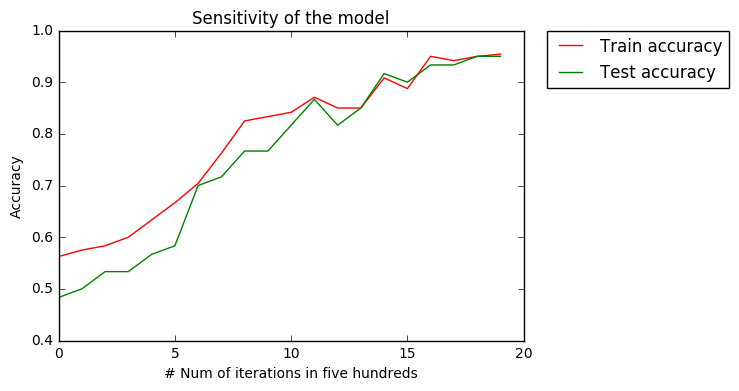

In [138]:
#5.1 4.5 Part 2
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("# Num of iterations in five hundreds")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [139]:
#5.1.4.5 Part 3
j = 0
train_acc = []
test_acc = []
for i in range(1, 4000, 1000):
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn(X_train,y_train,0.0005,i/10000,10000)
    # Performance check
    # Performance check
    training_precision= get_train_accuracy_ffn(X_train,y_train,W1,b1,W2,b2)
    test_precision= get_test_accuracy_ffn(X_test,y_test,W1,b1,W2,b2)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)

### Entering batch execution
### Exiting batch execution  |  Loss = 1.09843460139
Accuracy Train :  0.470833333333
Accuracy Test  :  0.416666666667
### Entering batch execution
### Exiting batch execution  |  Loss = 0.228804143783
Accuracy Train :  0.958333333333
Accuracy Test  :  0.95
### Entering batch execution
### Exiting batch execution  |  Loss = 0.223936469318
Accuracy Train :  0.9625
Accuracy Test  :  0.95
### Entering batch execution
### Exiting batch execution  |  Loss = 0.247371894666
Accuracy Train :  0.945833333333
Accuracy Test  :  0.933333333333


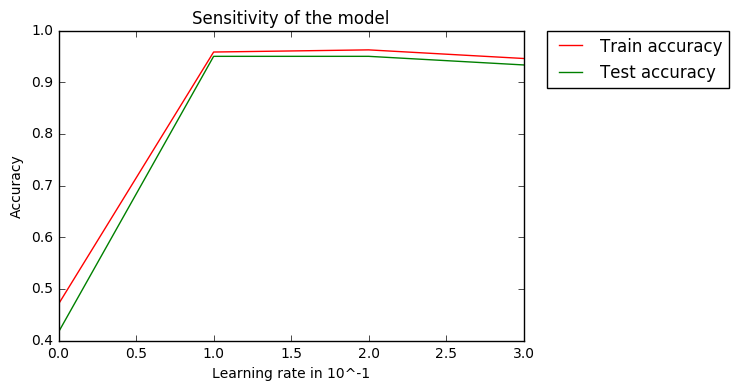

In [140]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Learning rate in 10^-1")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [144]:
# 5.1.4.6 What is the sensitivity of the model's performance to different regularization pa-
#         rameter values. Find the best regularization parameter using an exhaustive search
#         procedure. Describe your choice via suitable plots. What is the performance differ-
#         ence between using regularization and no regularization?

j = 0
train_acc = []
test_acc = []
for i in range(1000, 5000, 1000):
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn(X_train,y_train,i/1000000,0.1,10000)
    # Performance check
    # Performance check
    # Performance check
    training_precision= get_train_accuracy_ffn(X_train,y_train,W1,b1,W2,b2)
    test_precision= get_test_accuracy_ffn(X_test,y_test,W1,b1,W2,b2)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)
    

### Entering batch execution
### Exiting batch execution  |  Loss = 0.306966763802
Accuracy Train :  0.95
Accuracy Test  :  0.95
### Entering batch execution
### Exiting batch execution  |  Loss = 0.411681195336
Accuracy Train :  0.870833333333
Accuracy Test  :  0.9
### Entering batch execution
### Exiting batch execution  |  Loss = 0.463422655661
Accuracy Train :  0.854166666667
Accuracy Test  :  0.833333333333
### Entering batch execution
### Exiting batch execution  |  Loss = 0.553607277778
Accuracy Train :  0.8375
Accuracy Test  :  0.8


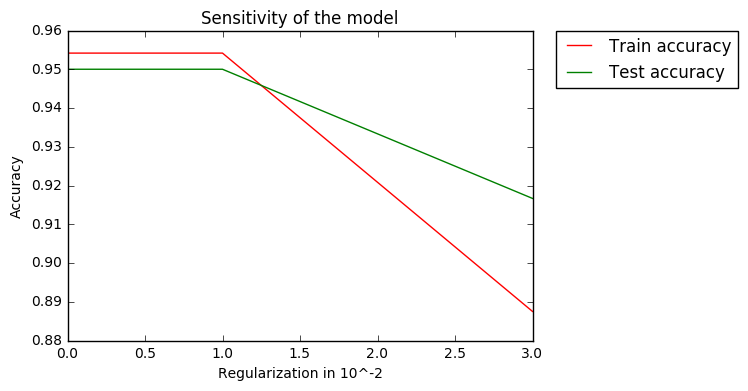

In [223]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Regularization in 10^-2")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [147]:

# 5.1.4.7 What is the sensitivity of the model's performance with respect to a different test
#         train split (50%:50%).


test_proportion = 0.5
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W1, b1, W2, b2, loss = my_own_batch_sgd_ffn(X_train,y_train,0.0005,0.1,10000)

get_train_accuracy_ffn(X_train,y_train,W1, b1, W2, b2)
get_test_accuracy_ffn(X_Val,y_Val, W1, b1, W2, b2)


(150, 2) (150,)
### Entering batch execution
### Exiting batch execution  |  Loss = 0.254456458073
Accuracy Train :  0.933333333333
Accuracy Test  :  0.933333333333


0.93333333333333335

In [231]:
#5.2 RELU
# 6.1.5.2
def two_layer_ffnn_leaky_relu(X_train,y_train,W1,b1,W2,b2,reg,learning_rate,iterate):

    #reg = 0.0001
    #learning_rate = 0.1
    for i in range(iterate):
                
        hidden_layer = np.dot(X_train,W1)+b1
        hidden_layer[hidden_layer<0] = 0.01*hidden_layer[np.where(hidden_layer<0)]
        
        scores = np.dot(hidden_layer,W2)+ b2
        
        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
        # compute the loss: average cross-entropy loss and regularization
        loss = logistic_loss(W2,b2,hidden_layer,y_train) + 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
        #if i % 1000 == 0:
         #   print("iteration: ", i, " loss = ",loss)
        num_examples = len(X_train)
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples
        # backpropate the gradient to the parameters (W,b)
        dW2 = np.dot(hidden_layer.T, dscores)         # is W equal to 'a' ref Week0 slides >>> dh/da * dg/dh
        db2 = np.sum(dscores, axis=0, keepdims=True)  
        dhidden = np.dot(dscores, W2.T)
        dhidden[hidden_layer < 0] = 0.01*dhidden[np.where(hidden_layer<0)]  # Doubt ???
        dW1 = np.dot(X_train.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)
        dW2 += reg * W2
        dW1 += reg * W1
        # perform a parameter update
        W1 += -learning_rate * dW1
        b1 += -learning_rate * db1
        W2 += -learning_rate * dW2
        b2 += -learning_rate * db2
    return W1, b1, W2, b2, loss;

In [232]:
#5.2
def my_own_batch_sgd_ffn_leaky(X_train,y_train,reg,learning_rate,num_iter):
    hid_lyr_neurons = 32
    D = X_train.shape[1]
    k = int(max(y_train)+ 1)
    W1 = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b1 = np.zeros((1,hid_lyr_neurons))
    W2 = 0.01*np.random.randn(hid_lyr_neurons,k)   
    b2 = np.zeros((1,k))
    W1, b1, W2, b2, loss = two_layer_ffnn_leaky_relu(X_train,y_train,W1,b1,W2,b2,reg,learning_rate,num_iter)
    print("### Exiting batch execution  |  Loss =", loss)
    return W1, b1, W2, b2, loss;

In [233]:
def get_test_accuracy_ffn_leaky(X_test,y_test,W1,b1,W2,b2):
    hidden_layer = np.dot(X_test,W1)+b1
    hidden_layer[hidden_layer<0] = 0.01*hidden_layer[np.where(hidden_layer<0)]
    y_hat_test = np.argmax((np.dot(hidden_layer, W2) + b2),axis = 1)
    test_precision = np.mean(y_hat_test == y_test)
    print("Accuracy Test : ",test_precision)
    return test_precision;
    
def get_train_accuracy_ffn_leaky(X_train,y_train,W1,b1,W2,b2):
    hidden_layer = np.dot(X_train,W1)+b1
    hidden_layer[hidden_layer<0] = 0.01*hidden_layer[np.where(hidden_layer<0)]
    y_hat_train = np.argmax((np.dot(hidden_layer, W2) + b2),axis = 1)
    training_precision = np.mean(y_hat_train == y_train)
    print("Accuracy Train : ",training_precision)
    return training_precision;

In [234]:
test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train,y_train,0.0005,0.1,10000)

get_train_accuracy_ffn_leaky(X_train,y_train,W1, b1, W2, b2)
get_test_accuracy_ffn_leaky(X_Val,y_Val, W1, b1, W2, b2)

(240, 2) (240,)
### Exiting batch execution  |  Loss = 0.121366866746
Accuracy Train :  0.954166666667
Accuracy Test :  0.966666666667


0.96666666666666667

In [175]:
#5.2.4.4
from sklearn import cross_validation
cv = cross_validation.KFold(len(X_train), n_folds=3, shuffle=True) # 43200 & 4800 each
for train_indices, test_indices in cv:  
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train[train_indices],y_train[train_indices],0.0005,0.1,10000)
    hidden_layer = np.dot(X_train[test_indices],W1)+b1
    hidden_layer[hidden_layer<0] = 0.01*hidden_layer[np.where(hidden_layer<0)]
    y_hat_test = np.argmax((np.dot(hidden_layer,W2)+ b2), axis = 1)
    test_precision = np.mean(y_hat_test == y_train[test_indices])
    print(test_precision)

### Exiting batch execution  |  Loss = 0.203753503298
0.8875
### Exiting batch execution  |  Loss = 0.234487959329
0.925
### Exiting batch execution  |  Loss = 0.253329030632
0.925


In [171]:
#5.2 4.5
# What is the sensitivity of the model's performance to different learning rates
# the number of gradient descent iterations. Describe via suitable plots.

test_proportion = 0.2
X_train, X_test, y_train, y_test = split_data(X,y,test_proportion)
j = 0
train_acc = []
test_acc = []
for i in range(10, 10000, 500):
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train,y_train,0.0005,0.1,i)
    
    # Performance check
    training_precision= get_train_accuracy_ffn_leaky(X_train,y_train,W1,b1,W2,b2)
    test_precision= get_test_accuracy_ffn_leaky(X_test,y_test,W1,b1,W2,b2)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)


(240, 2) (240,)
### Exiting batch execution  |  Loss = 1.09854568496
Accuracy Train :  0.345833333333
Accuracy Test :  0.4
### Exiting batch execution  |  Loss = 0.714531019418
Accuracy Train :  0.570833333333
Accuracy Test :  0.5
### Exiting batch execution  |  Loss = 0.674543889439
Accuracy Train :  0.591666666667
Accuracy Test :  0.533333333333
### Exiting batch execution  |  Loss = 0.643654330674
Accuracy Train :  0.6125
Accuracy Test :  0.566666666667
### Exiting batch execution  |  Loss = 0.623639495206
Accuracy Train :  0.6375
Accuracy Test :  0.566666666667
### Exiting batch execution  |  Loss = 0.579617380821
Accuracy Train :  0.670833333333
Accuracy Test :  0.616666666667
### Exiting batch execution  |  Loss = 0.480010113583
Accuracy Train :  0.729166666667
Accuracy Test :  0.7
### Exiting batch execution  |  Loss = 0.428425957634
Accuracy Train :  0.783333333333
Accuracy Test :  0.733333333333
### Exiting batch execution  |  Loss = 0.356408520904
Accuracy Train :  0.84166666

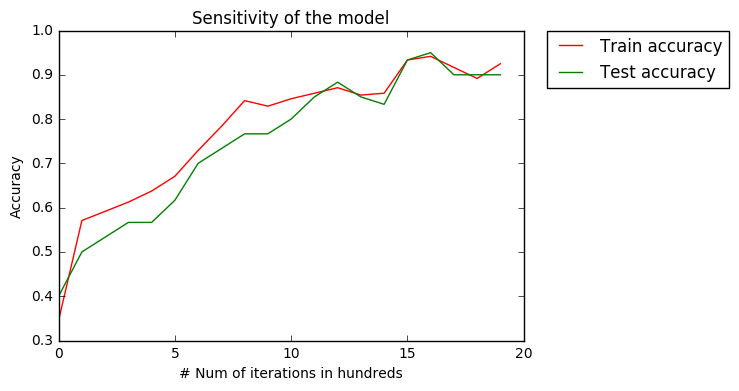

In [176]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("# Num of iterations in hundreds")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [180]:
#5.2.4.5 Gradient Descent
j = 0
train_acc = []
test_acc = []
for i in range(1, 4000, 1000):
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train,y_train,0.0005,i/10000,10000)
    # Performance check
    # Performance check
    training_precision= get_train_accuracy_ffn_leaky(X_train,y_train,W1,b1,W2,b2)
    test_precision= get_test_accuracy_ffn_leaky(X_test,y_test,W1,b1,W2,b2)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)

### Exiting batch execution  |  Loss = 1.09861657676
Accuracy Train :  0.429166666667
Accuracy Test :  0.4
### Exiting batch execution  |  Loss = 0.233424479267
Accuracy Train :  0.958333333333
Accuracy Test :  0.95
### Exiting batch execution  |  Loss = 0.203458719626
Accuracy Train :  0.970833333333
Accuracy Test :  0.983333333333
### Exiting batch execution  |  Loss = 0.250674137343
Accuracy Train :  0.945833333333
Accuracy Test :  0.933333333333


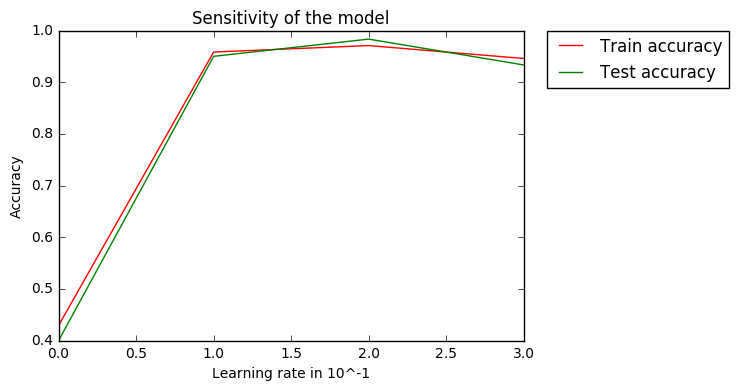

In [182]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Learning rate in 10^-1")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [183]:
# 5.2.4.6 What is the sensitivity of the model's performance to different regularization pa-
#         rameter values. Find the best regularization parameter using an exhaustive search
#         procedure. Describe your choice via suitable plots. What is the performance differ-
#         ence between using regularization and no regularization?

j = 0
train_acc = []
test_acc = []
for i in range(1000, 5000, 1000):
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train,y_train,i/1000000,0.1,10000)
    # Performance check
    # Performance check
    # Performance check
    training_precision= get_train_accuracy_ffn_leaky(X_train,y_train,W1,b1,W2,b2)
    test_precision= get_test_accuracy_ffn_leaky(X_test,y_test,W1,b1,W2,b2)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)
    

### Exiting batch execution  |  Loss = 0.310174277317
Accuracy Train :  0.9375
Accuracy Test :  0.933333333333
### Exiting batch execution  |  Loss = 0.424524305284
Accuracy Train :  0.8875
Accuracy Test :  0.883333333333
### Exiting batch execution  |  Loss = 0.480686111568
Accuracy Train :  0.854166666667
Accuracy Test :  0.8
### Exiting batch execution  |  Loss = 0.520431251627
Accuracy Train :  0.833333333333
Accuracy Test :  0.816666666667


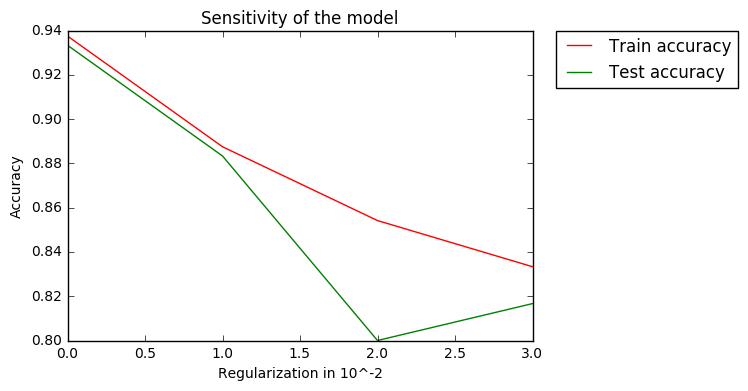

In [184]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Regularization in 10^-2")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [185]:
#5.2.4.7


test_proportion = 0.5
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train,y_train,0.0005,0.1,10000)

get_train_accuracy_ffn_leaky(X_train,y_train,W1, b1, W2, b2)
get_test_accuracy_ffn_leaky(X_Val,y_Val, W1, b1, W2, b2)


(150, 2) (150,)
### Exiting batch execution  |  Loss = 0.255425793386
Accuracy Train :  0.94
Accuracy Test :  0.94


0.93999999999999995

In [242]:
def my_own_batch_sgd_ffn_maxout(X_train,y_train,reg,learning_rate,num_iter):
    hid_lyr_neurons = 32
    D = X_train.shape[1]
    k = int(max(y_train)+ 1)
    W = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b = np.zeros((1,hid_lyr_neurons))
    W2 = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b2 = np.zeros((1,hid_lyr_neurons))
    W3 = 0.01 * np.random.randn(hid_lyr_neurons,k)
    b3 = np.zeros((1,k))
    W,b,W2,b2,W3,b3,total_loss = reg_log_loss_layer_maxout(X_train,y_train,W,b,W2,b2,W3,b3,reg,learning_rate,num_iter)
    print("### Exiting batch execution  |  Loss =", loss)
    return W,b,W2,b2,W3,b3,total_loss;

In [243]:
#5.3
def reg_log_loss_layer_maxout(x_train,y_train,W,b,W2,b2,W3,b3,reg,step_size,iterations):
    
    num_examples = x_train.shape[0]
    
    total_loss = np.zeros(iterations)
    for i in range(0, iterations):
    
        hidden_layer = np.dot(x_train, W) + b # note, ReLU activation
        hidden_layer1 = np.dot(x_train, W2) + b2
        scores = np.dot(np.maximum(hidden_layer, hidden_layer1), W3) + b3
    
    # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)# [N x K]
    #axis = 1 means row wise addition
    
        corect_logprobs = -np.log(probs[range(num_examples),y_train])
   
        data_loss = np.sum(corect_logprobs)/num_examples
        L2_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2) + 0.5*reg*np.sum(W3*W3)
        log_L2_loss = data_loss + L2_loss
        #log_L1_loss = data_loss + L1_loss
        #L1_loss = 0.5*reg*np.sum(np.absolute(W)) + 0.5*reg*np.sum(np.absolute(W2)) + 0.5*reg*np.sum(np.absolute(W3))
        #total_loss[i]=log_L2_loss 
        #if i % 10 == 0:
        #    print("iteration: ", i, " loss = ",log_L2_loss)
    # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples
  
    # backpropate the gradient to the parameters (W,b)
        dW3 = np.dot(np.maximum(hidden_layer.T, hidden_layer1.T), dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True) 
        
    # next backprop into hidden layer
        dhidden = np.dot(dscores, W3.T)
        dhidden1 = np.dot(dscores, W3.T)
    # backprop the ReLU non-linearity
        dhidden[hidden_layer1 < hidden_layer] = 0*dhidden[np.where(hidden_layer1 < hidden_layer)] #backpropogate the relu non-linearity or not
        dhidden1[hidden_layer1 > hidden_layer] = 0*dhidden[np.where(hidden_layer1 > hidden_layer)]
    # backpropate the gradient to the parameters (W,b)
        dW2 = np.dot(x_train.T, dhidden)
        db2 = np.sum(dhidden, axis=0, keepdims=True)
        
    # next backprop into hidden layer
        #dhidden1 = np.dot(dscores, x_train.T)
    # backprop the ReLU non-linearity
        #dhidden1[hidden_layer <= 0] = 0
        #dhidden = np.maximum(dhidden,dhidden1)
        
    # finally into W,b
        dW = np.dot(x_train.T, dhidden1)
        db = np.sum(dhidden1, axis=0, keepdims=True)
  
  
      # add regularization gradient contribution
        dW3 += reg * W3
        dW2 += reg * W2
        dW  += reg * W
  
     # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W3 += -step_size * dW3
        b3 += -step_size * db3
    return W,b,W2,b2,W3,b3,total_loss;

In [244]:
def get_train_accuracy_maxout(X_train,y_train,W, b, W2, b2, W3, b3):
    y_hat_train = np.argmax(np.dot(np.maximum(np.dot(X_train, W) + b, np.dot(X_train, W2) + b2), W3) + b3, axis = 1)
    training_precision = np.mean(y_hat_train == y_train)
    print("Accuracy Train : ",training_precision)
    return training_precision;

def get_test_accuracy_maxout(X_test,y_test,W, b, W2, b2, W3, b3):
    y_hat_test = np.argmax(np.dot(np.maximum(np.dot(X_test, W) + b, np.dot(X_test, W2) + b2), W3) + b3, axis = 1)
    test_precision = np.mean(y_hat_test == y_test)
    print("Accuracy Test  : ",test_precision)
    return test_precision;

In [245]:
test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W, b, W2, b2, W3, b3, loss = my_own_batch_sgd_ffn_maxout(X_train,y_train,0.0005,0.1,10000)

get_train_accuracy_maxout(X_train,y_train,W, b, W2, b2, W3, b3)
get_test_accuracy_maxout(X_test,y_test,W, b, W2, b2, W3, b3)

(240, 2) (240,)
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
Accuracy Train :  0.954166666667
Accuracy Test  :  0.95


0.94999999999999996

In [198]:
#5.3.4.4
from sklearn import cross_validation
cv = cross_validation.KFold(len(X_train), n_folds=10, shuffle=True) # 43200 & 4800 each
for train_indices, test_indices in cv:  
    W, b, W2, b2, W3, b3, loss = my_own_batch_sgd_ffn_maxout(X_train[train_indices],y_train[train_indices],0.0005,0.1,10000)
    y_hat_test = np.argmax(np.dot(np.maximum(np.dot(X_train[test_indices], W) + b, np.dot(X_train[test_indices], W2) + b2), W3) + b3, axis = 1)
    test_precision = np.mean(y_hat_test == y_train[test_indices])
    print(test_precision)
    

### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
0.916666666667
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
0.916666666667
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
0.958333333333
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
0.916666666667
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
0.958333333333
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
0.916666666667
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
0.916666666667
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
1.0
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
1.0
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
0.958333333333


In [203]:
#5.3 4.5
# What is the sensitivity of the model's performance to different learning rates
# the number of gradient descent iterations. Describe via suitable plots.

test_proportion = 0.2
X_train, X_test, y_train, y_test = split_data(X,y,test_proportion)
j = 0
train_acc = []
test_acc = []
for i in range(10, 10000, 500):
    W1, b1, W2, b2,W3,b3,loss = my_own_batch_sgd_ffn_maxout(X_train,y_train,0.0005,0.1,i)
    
    # Performance check
    training_precision= get_train_accuracy_maxout(X_train,y_train,W1,b1,W2,b2,W3,b3)
    test_precision= get_test_accuracy_maxout(X_test,y_test,W1,b1,W2,b2,W3,b3)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)


(240, 2) (240,)
### Exiting batch execution  |  Loss = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Accuracy Train :  0.508333333333
Accuracy Test  :  0.5
### Exiting batch execution  |  Loss = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Accuracy Train :  0.579166666667
Accuracy Test  :  0.533333333333
### Exiting batch execution  |  Loss = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0. 

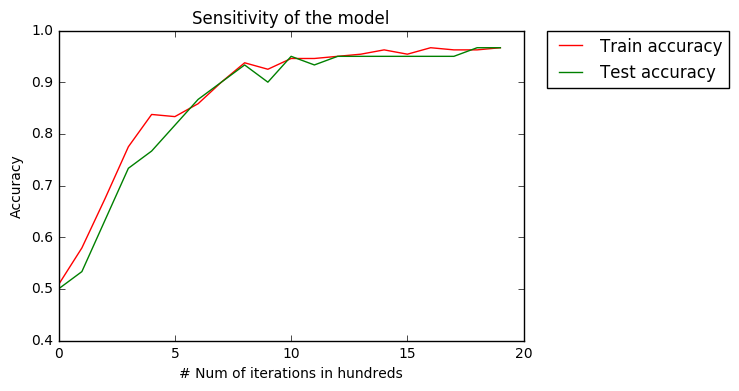

In [205]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("# Num of iterations in hundreds")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [206]:
#5.3.4.5 Gradient Descent
j = 0
train_acc = []
test_acc = []
for i in range(1, 4000, 1000):
    W1, b1, W2, b2,W3,b3,loss = my_own_batch_sgd_ffn_maxout(X_train,y_train,0.0005,i/10000,10000)
    # Performance check
    # Performance check
    training_precision= get_train_accuracy_maxout(X_train,y_train,W1,b1,W2,b2,W3,b3)
    test_precision= get_test_accuracy_maxout(X_test,y_test,W1,b1,W2,b2,W3,b3)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)

### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
Accuracy Train :  0.533333333333
Accuracy Test  :  0.483333333333
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
Accuracy Train :  0.966666666667
Accuracy Test  :  0.983333333333
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
Accuracy Train :  0.979166666667
Accuracy Test  :  0.983333333333
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
Accuracy Train :  0.9875
Accuracy Test  :  1.0


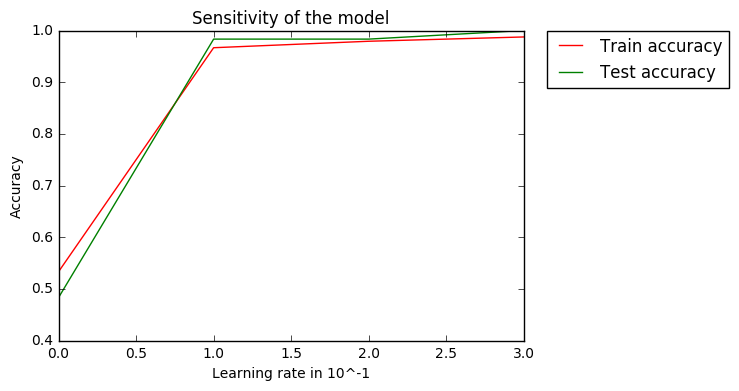

In [207]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Learning rate in 10^-1")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [210]:
# 5.3.4.6 What is the sensitivity of the model's performance to different regularization pa-
#         rameter values. Find the best regularization parameter using an exhaustive search
#         procedure. Describe your choice via suitable plots. What is the performance differ-
#         ence between using regularization and no regularization?

j = 0
train_acc = []
test_acc = []
for i in range(1000, 5000, 1000):
    W1, b1, W2, b2,W3,b3,loss = my_own_batch_sgd_ffn_maxout(X_train,y_train,i/1000000,0.1,10000)
    # Performance check
    # Performance check
    # Performance check
    training_precision= get_train_accuracy_maxout(X_train,y_train,W1,b1,W2,b2,W3,b3)
    test_precision= get_test_accuracy_maxout(X_test,y_test,W1,b1,W2,b2,W3,b3)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)

### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
Accuracy Train :  0.954166666667
Accuracy Test  :  0.95
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
Accuracy Train :  0.954166666667
Accuracy Test  :  0.95
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
Accuracy Train :  0.920833333333
Accuracy Test  :  0.933333333333
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
Accuracy Train :  0.8875
Accuracy Test  :  0.916666666667


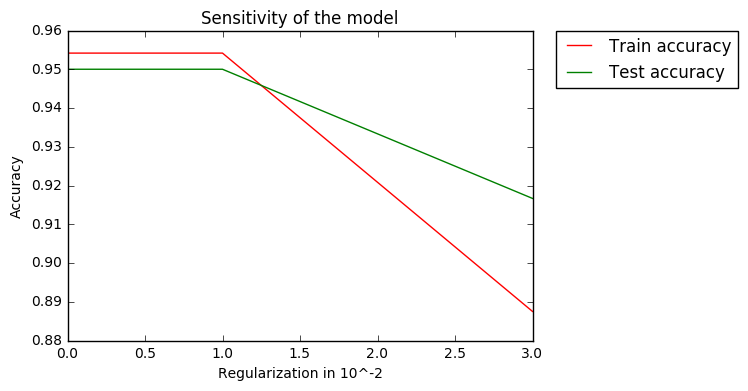

In [211]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Regularization in 10^-2")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [246]:
#5.3.4.7
test_proportion = 0.5
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W, b, W2, b2, W3, b3, loss = my_own_batch_sgd_ffn_maxout(X_train,y_train,0.0005,0.1,10000)

get_train_accuracy_maxout(X_train,y_train,W, b, W2, b2, W3, b3)
get_test_accuracy_maxout(X_test,y_test,W, b, W2, b2, W3, b3)

(150, 2) (150,)
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
Accuracy Train :  0.94
Accuracy Test  :  0.916666666667


0.91666666666666663

In [ ]:
## *When Hidden Layer Change From 10 to 1000*

In [216]:
def my_own_batch_sgd_ffn_neuron(X_train,y_train,reg,learning_rate,num_iter):
    hid_lyr_neurons = 10
    D = X_train.shape[1]
    k = int(max(y_train)+ 1)
    W1 = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b1 = np.zeros((1,hid_lyr_neurons))
    W2 = 0.01*np.random.randn(hid_lyr_neurons,k)   
    b2 = np.zeros((1,k))
    batch_size = 48
    
    W1, b1, W2, b2, loss = two_layer_ffnn(X_train,y_train,W1,b1,W2,b2,reg,learning_rate,num_iter)
    print("### Exiting batch execution  |  Loss =", loss)
    return W1, b1, W2, b2, loss;

test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_neuron(X_train,y_train,0.0005,0.1,10000)

get_train_accuracy_ffn(X_train,y_train,W1, b1, W2, b2)
get_test_accuracy_ffn(X_Val,y_Val, W1, b1, W2, b2)

(240, 2) (240,)
### Exiting batch execution  |  Loss = 0.296975200557
Accuracy Train :  0.908333333333
Accuracy Test  :  0.9


0.90000000000000002

In [217]:
def my_own_batch_sgd_ffn_neuron(X_train,y_train,reg,learning_rate,num_iter):
    hid_lyr_neurons = 1000
    D = X_train.shape[1]
    k = int(max(y_train)+ 1)
    W1 = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b1 = np.zeros((1,hid_lyr_neurons))
    W2 = 0.01*np.random.randn(hid_lyr_neurons,k)   
    b2 = np.zeros((1,k))
    batch_size = 48
    
    W1, b1, W2, b2, loss = two_layer_ffnn(X_train,y_train,W1,b1,W2,b2,reg,learning_rate,num_iter)
    print("### Exiting batch execution  |  Loss =", loss)
    return W1, b1, W2, b2, loss;

test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_neuron(X_train,y_train,0.0005,0.1,10000)

get_train_accuracy_ffn(X_train,y_train,W1, b1, W2, b2)
get_test_accuracy_ffn(X_Val,y_Val, W1, b1, W2, b2)

(240, 2) (240,)
### Exiting batch execution  |  Loss = 0.195872490106
Accuracy Train :  0.970833333333
Accuracy Test  :  0.95


0.94999999999999996

In [219]:
def my_own_batch_sgd_ffn_leaky(X_train,y_train,reg,learning_rate,num_iter):
    hid_lyr_neurons = 10
    D = X_train.shape[1]
    k = int(max(y_train)+ 1)
    W1 = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b1 = np.zeros((1,hid_lyr_neurons))
    W2 = 0.01*np.random.randn(hid_lyr_neurons,k)   
    b2 = np.zeros((1,k))
    W1, b1, W2, b2, loss = two_layer_ffnn_leaky_relu(X_train,y_train,W1,b1,W2,b2,reg,learning_rate,num_iter)
    print("### Exiting batch execution  |  Loss =", loss)
    return W1, b1, W2, b2, loss;

test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train,y_train,0.0005,0.1,10000)

get_train_accuracy_ffn_leaky(X_train,y_train,W1, b1, W2, b2)
get_test_accuracy_ffn_leaky(X_Val,y_Val, W1, b1, W2, b2)

(240, 2) (240,)
### Exiting batch execution  |  Loss = 0.253645807437
Accuracy Train :  0.933333333333
Accuracy Test :  0.933333333333


0.93333333333333335

In [220]:
def my_own_batch_sgd_ffn_leaky(X_train,y_train,reg,learning_rate,num_iter):
    hid_lyr_neurons = 1000
    D = X_train.shape[1]
    k = int(max(y_train)+ 1)
    W1 = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b1 = np.zeros((1,hid_lyr_neurons))
    W2 = 0.01*np.random.randn(hid_lyr_neurons,k)   
    b2 = np.zeros((1,k))
    W1, b1, W2, b2, loss = two_layer_ffnn_leaky_relu(X_train,y_train,W1,b1,W2,b2,reg,learning_rate,num_iter)
    print("### Exiting batch execution  |  Loss =", loss)
    return W1, b1, W2, b2, loss;

test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train,y_train,0.0005,0.1,10000)

get_train_accuracy_ffn_leaky(X_train,y_train,W1, b1, W2, b2)
get_test_accuracy_ffn_leaky(X_Val,y_Val, W1, b1, W2, b2)

(240, 2) (240,)
### Exiting batch execution  |  Loss = 0.202582891825
Accuracy Train :  0.966666666667
Accuracy Test :  0.95


0.94999999999999996

In [222]:
def my_own_batch_sgd_ffn_maxout(X_train,y_train,reg,learning_rate,num_iter):
    hid_lyr_neurons = 10  # Changed number of hidden units
    D = X_train.shape[1]
    k = int(max(y_train)+ 1)
    W = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b = np.zeros((1,hid_lyr_neurons))
    W2 = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b2 = np.zeros((1,hid_lyr_neurons))
    W3 = 0.01 * np.random.randn(hid_lyr_neurons,k)
    b3 = np.zeros((1,k))
    W,b,W2,b2,W3,b3,total_loss = reg_log_loss_layer_maxout(X_train,y_train,W,b,W2,b2,W3,b3,reg,learning_rate,num_iter)
    print("### Exiting batch execution  |  Loss =", loss)
    return W,b,W2,b2,W3,b3,total_loss;

test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W, b, W2, b2, W3, b3, loss = my_own_batch_sgd_ffn_maxout(X_train,y_train,0.0005,0.1,10000)

get_train_accuracy_maxout(X_train,y_train,W, b, W2, b2, W3, b3)
get_test_accuracy_maxout(X_test,y_test,W, b, W2, b2, W3, b3)

(240, 2) (240,)
### Exiting batch execution  |  Loss = [ 0.  0.  0. ...,  0.  0.  0.]
Accuracy Train :  0.966666666667
Accuracy Test  :  0.983333333333


0.98333333333333328

In [221]:
def my_own_batch_sgd_ffn_maxout(X_train,y_train,reg,learning_rate,num_iter):
    hid_lyr_neurons = 1000  # Changed number of hidden units
    D = X_train.shape[1]
    k = int(max(y_train)+ 1)
    W = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b = np.zeros((1,hid_lyr_neurons))
    W2 = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b2 = np.zeros((1,hid_lyr_neurons))
    W3 = 0.01 * np.random.randn(hid_lyr_neurons,k)
    b3 = np.zeros((1,k))
    W,b,W2,b2,W3,b3,total_loss = reg_log_loss_layer_maxout(X_train,y_train,W,b,W2,b2,W3,b3,reg,learning_rate,num_iter)
    print("### Exiting batch execution  |  Loss =", loss)
    return W,b,W2,b2,W3,b3,total_loss;

test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W, b, W2, b2, W3, b3, loss = my_own_batch_sgd_ffn_maxout(X_train,y_train,0.0005,0.1,10000)

get_train_accuracy_maxout(X_train,y_train,W, b, W2, b2, W3, b3)
get_test_accuracy_maxout(X_test,y_test,W, b, W2, b2, W3, b3)

(240, 2) (240,)
### Exiting batch execution  |  Loss = 0.202582891825
Accuracy Train :  0.979166666667
Accuracy Test  :  0.983333333333


0.98333333333333328